In [2]:
import pandas as pd
import numpy as np
import pandas.util.testing as tm
import seaborn as sns
sns.set()
from pandas_profiling import ProfileReport
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.linear_model import LinearRegression
from xgboost import XGBRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error 
import os
import datetime 
import math
import re

__OPIS DANYCH__ /Dorota

In [ ]:
f = open("data/data_description.txt", "r")
print(f.read())

__IMPORT I BADANIE DANYCH__ /Maciek

In [ ]:
#import i ustawienie formatów
df = pd.read_csv('AmesHousing.csv')
pd.set_option('display.max_columns', 2000)
pd.set_option('display.max_rows', 85)
pd.options.display.float_format = '{:20.2f}'.format

In [ ]:
df.head(10)

In [ ]:
#ustawienie indexu
df = df.set_index("Order")

In [ ]:
print("Shape of df: ", df.shape)

In [ ]:
df.info()

In [ ]:
ProfileReport(df, title='Opis danych', minimal=True)
#profile.to_file(output_file="raport_min.html") #możliwość wyrzucenia raportu do pliku HTML

In [ ]:
# opis danych numerycznych
df.describe(include=[np.number], percentiles=[.5]) \
    .transpose().drop("count", axis=1)

In [ ]:
# dane kategoryczne
obj = list(df.loc[:,df.dtypes == 'object'].columns.values)
obj

In [ ]:
# dane kategoryczne opis kategorii
df.describe(include=[np.object]).transpose() \
    .drop("count", axis=1)

__CENY DOMÓW__

In [ ]:
df['SalePrice'].describe()

In [ ]:
plt.figure(figsize=(10,8))
bar = sns.distplot(df['SalePrice'])
bar.legend(["Skewness: {:.2f}".format(df['SalePrice'].skew())]);

__MAPA KORELACJI__

In [ ]:
plt.figure(figsize=(30,30))
ax = sns.heatmap(df.corr(), cmap = "coolwarm", annot=True, linewidth=2)

In [ ]:
# zmienne o wysokim współczynniku korelacji
high_corr = df.corr()
high_corr_features = high_corr.index[abs(high_corr["SalePrice"]) >= 0.5] 
high_corr_features

In [ ]:
# mapa zmiennych o wysokim współczynniku korelacji
plt.figure(figsize=(20,8))
ax = sns.heatmap(df[high_corr_features].corr(), cmap = "coolwarm", annot=True, linewidth=3)

In [ ]:
# wysoka korelacja a cena
plt.figure(figsize=(16,9))
for i in range(len(high_corr_features)):
    if i <= 9:
        plt.subplot(3,4,i+1)
        plt.subplots_adjust(hspace = 0.5,wspace = 0.5)
        sns.regplot(data=df, x = high_corr_features[i], y = 'SalePrice')

__BRAKI W DANYCH - UZUPŁNIENIE DANYCH__

In [ ]:
#mapa braków w danych
plt.figure(figsize=(30,15))
sns.heatmap(df.isnull())

In [ ]:
#braki danych ilościowo i procentowo
num_missing = df.isna().sum()
num_missing = num_missing[num_missing > 0]
percent_missing = num_missing * 100 / df.shape[0]
pd.concat([num_missing, percent_missing], axis=1, 
          keys=['Missing Values', 'Percentage']).\
          sort_values(by="Missing Values", ascending=False)

In [ ]:
missing_col = df.columns[df.isnull().any()]
missing_col

In [ ]:
# dane, gdzie brak danych oznacza 0
df["Pool QC"].fillna("No Pool", inplace=True)
df['Misc Feature'].fillna('No feature', inplace=True)
df['Alley'].fillna('No Alley', inplace=True)
df['Fence'].fillna('No Fence', inplace=True)
df['Fireplace Qu'].fillna('No Fireplace', inplace=True)
df['Lot Frontage'].fillna(0, inplace=True)
df['Mas Vnr Area'].fillna(0, inplace=True)
df['Mas Vnr Type'].fillna("None", inplace=True)
df['Electrical'].fillna(df['Electrical'].mode()[0], inplace=True)

In [ ]:
# podgląd danych
garage_columns = [col for col in df.columns if col.startswith("Garage")]
df[df['Garage Cars'].isna()][garage_columns]

In [ ]:
# podgląd danych
df[~pd.isna(df['Garage Type']) & 
        pd.isna(df['Garage Qual'])][garage_columns]

In [ ]:
# uzupełnienie danych
df['Garage Cars'].fillna(0, inplace=True)
df['Garage Area'].fillna(0, inplace=True)

df.loc[~pd.isna(df['Garage Type']) & 
            pd.isna(df['Garage Qual']), "Garage Type"] = "No Garage"

for col in ['Garage Type', 'Garage Finish', 'Garage Qual', 'Garage Cond']:
    df[col].fillna('No Garage', inplace=True)
    
df['Garage Yr Blt'].fillna(0, inplace=True)

In [ ]:
#podgląd danych
bsmt_columns = [col for col in df.columns if "Bsmt" in col]
df[df['Bsmt Half Bath'].isna()][bsmt_columns]

In [ ]:
# podgląd danych
df[~pd.isna(df['Bsmt Cond']) & 
        pd.isna(df['Bsmt Exposure'])][bsmt_columns]

In [ ]:
# podgląd danych
df[~pd.isna(df['Bsmt Cond']) & 
        pd.isna(df['BsmtFin Type 2'])][bsmt_columns]

In [ ]:
# uzupełnienie danych
for col in ["Bsmt Half Bath", "Bsmt Full Bath", "Total Bsmt SF", 
            "Bsmt Unf SF", "BsmtFin SF 2", "BsmtFin SF 1"]:
    df[col].fillna(0, inplace=True)

df.loc[~pd.isna(df['Bsmt Cond']) & 
            pd.isna(df['Bsmt Exposure']), "Bsmt Exposure"] = "No"
df.loc[~pd.isna(df['Bsmt Cond']) & 
            pd.isna(df['BsmtFin Type 2']), "BsmtFin Type 2"] = "Unf"

for col in ["Bsmt Exposure", "BsmtFin Type 2", 
            "BsmtFin Type 1", "Bsmt Qual", "Bsmt Cond"]:
    df[col].fillna("No Basement", inplace=True)

In [ ]:
# usunięcie kolumny PID (numer)
df.drop(['PID'], axis=1, inplace=True)

In [ ]:
df.isna().values.sum()

__Zamiana zmiennych kategorczynych__

In [25]:
mp = {'Ex':4,'Gd':3,'TA':2,'Fa':1,'Po':0}
df['Exter Qual'] = df['Exter Qual'].map(mp)
df['Exter Cond'] = df['Exter Cond'].map(mp)
df['Heating QC'] = df['Heating QC'].map(mp)
df['Kitchen Qual'] = df['Kitchen Qual'].map(mp)

mp = {'Ex':5,'Gd':4,'TA':3,'Fa':2,'Po':1,'No Basement':0}
df['Bsmt Qual'] = df['Bsmt Qual'].map(mp)
df['Bsmt Cond'] = df['Bsmt Cond'].map(mp)
df['Bsmt Exposure'] = df['Bsmt Exposure'].map(
    {'Gd':4,'Av':3,'Mn':2,'No':1,'No Basement':0})

mp = {'GLQ':6,'ALQ':5,'BLQ':4,'Rec':3,'LwQ':2,'Unf':1,'No Basement':0}
df['BsmtFin Type 1'] = df['BsmtFin Type 1'].map(mp)
df['BsmtFin Type 2'] = df['BsmtFin Type 2'].map(mp)

df['Central Air'] = df['Central Air'].map({'Y':1,'N':0})
df['Functional'] = df['Functional'].map(
    {'Typ':7,'Min1':6,'Min2':5,'Mod':4,'Maj1':3,
     'Maj2':2,'Sev':1,'Sal':0})
df['Fireplace Qu'] = df['Fireplace Qu'].map(
    {'Ex':5,'Gd':4,'TA':3,'Fa':2,'Po':1,'No Fireplace':0})
df['Garage Finish'] = df['Garage Finish'].map(
    {'Fin':3,'RFn':2,'Unf':1,'No Garage':0})
df['Garage Qual'] = df['Garage Qual'].map(
    {'Ex':5,'Gd':4,'TA':3,'Fa':2,'Po':1,'No Garage':0})
df['Garage Cond'] = df['Garage Cond'].map(
    {'Ex':5,'Gd':4,'TA':3,'Fa':2,'Po':1,'No Garage':0})
df['Pool QC'] = df['Pool QC'].map(
    {'Ex':4,'Gd':3,'TA':2,'Fa':1,'No Pool':0})
df['Land Slope'] = df['Land Slope'].map(
    {'Sev': 2, 'Mod': 1, 'Gtl': 0})
df['Fence'] = df['Fence'].map(
    {'GdPrv':4,'MnPrv':3,'GdWo':2,'MnWw':1,'No Fence':0})

In [26]:
df = pd.get_dummies(df)

__standaryzacja danych__

In [27]:
scaler = StandardScaler()
df.loc[:, df.columns != 'SalePrice'] = scaler.fit_transform(
    df.loc[:, df.columns != 'SalePrice'])

__Podział na x i y i zbiory treningowy i testowy__

In [28]:
y = df['SalePrice']
X = df.drop(['SalePrice'], axis=1)

In [29]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .25, random_state=3)

## Zapisywanie wyników

In [30]:
time_string = datetime.datetime.now().strftime('%Y%m%d_%H%M%S')

In [31]:
def check_dir(name, path):
    try:
        os.mkdir("{0}/{1}".format(path,name))
    except:
        print('dir exists')

In [32]:
def cv_df(grid):
    cv = grid.n_splits_
    results = grid.cv_results_
    #### ------ nazwy parametrow
    names = list(results['params'][0].keys())
    ###----- dataframe z zestawem parametrów
    param_dict = {}
    for n in names:
        par_list = [ results['params'][i][n] for i in range(len(results['params'])) ]
        param_dict[n] = par_list
    param_pd = pd.DataFrame(param_dict)
        
    ##------ dodawanie wyników z każdego folda do wynikowego DF
    results_pd= pd.DataFrame()
    for i in range(cv):
        tmp = param_pd.copy()
        tmp['score'] = results['split{0}_test_score'.format(i)]
        results_pd = results_pd.append(tmp)
        
    time_string = datetime.datetime.now().strftime('%Y%m%d_%H%M%S')
    exp = "[^(]*"
    
    name = (re.search(exp, str(grid.estimator))).group()
    
    results_pd.to_csv(f'results//{name}_{time_string}.csv')
    return results_pd

# Linear Regression

In [120]:
params = {
    "n_jobs" : [1,3,5,10,15,20,30,40,50,60]
}

regression = LinearRegression()

grid = GridSearchCV(regression, params, cv=5)
grid.fit(X_train, y_train)
cv_df(grid)

,n_jobs,score
0,1,-2765112137827198619877376.00
1,3,-2765112137827198619877376.00
2,5,-2765112137827198619877376.00
3,10,-2765112137827198619877376.00
4,15,-2765112137827198619877376.00
5,20,-2765112137827198619877376.00
6,30,-2765112137827198619877376.00
7,40,-2765112137827198619877376.00
8,50,-2765112137827198619877376.00
9,60,-2765112137827198619877376.00


## RandomForestRegressor

In [35]:
def rmse(predict, actual):
    predict = np.array(predict)
    actual = np.array(actual)

    distance = predict - actual

    square_distance = distance ** 2

    mean_square_distance = square_distance.mean()

    score = np.sqrt(mean_square_distance)

    return score

rmse_score = make_scorer(rmse, greater_is_better=False)



In [43]:
# poszukiwanie najlepszych parametrów lasu
params = {
     #"min_samples_split": range(2, 21, 2),
      "min_samples_leaf": [10,50, 100],
      "n_estimators": [50,90, 125],
      "max_depth": [5,10,15,20],
      "criterion": ['mse']
 }

forest = RandomForestRegressor()
grid= GridSearchCV(forest, params, cv=5)
grid.fit(X_train, y_train)
cv_df(grid)
print(grid.best_params_)
# print(grid.score(X_test, y_test))

{'criterion': 'mse', 'max_depth': 15, 'min_samples_leaf': 10, 'n_estimators': 50}


In [47]:
# test najlepszych parametrów z RMSE scorerem
forest_best = RandomForestRegressor(criterion = 'mse', max_depth= 15, min_samples_leaf = 10, n_estimators = 50)
forest_best.fit(X_train, y_train)
print(f'R^2 score: {forest_best.score(X_train, y_train)}')
y_pred = forest_best.predict(X_test)
rmse = math.sqrt(mean_squared_error(y_test, y_pred))
print(f' RMSE: {rmse}')

R^2 score: 0.9167701353912839
 RMSE: 24821.835445921293


In [52]:
forest_best = RandomForestRegressor(criterion = 'mae', max_depth= 15, min_samples_leaf = 10, n_estimators = 50)
forest_best.fit(X_train, y_train)
print(f'R^2 Score: {forest_best.score(X_train, y_train)}')
y_pred = forest_best.predict(X_test)
forest_best_mae = mean_absolute_error(y_test, y_pred)
print(f'MAE: {forest_best_mae}')

R^2 Score: 0.89820956268543
MAE: 16632.77275579809


__XGBoost__

In [130]:
def XGB_score (x_train, y_train, x_test, y_test):
    max_depth = [3, 4, 5, 6, None]
    learning_rate = [0.01, 0.05, 0.01, 0.3]
    n_estimators = [10, 50, 100, 200, 500, 2500]
    best = 0
    best_model = ''
    for d in max_depth:
        for l in learning_rate:
            for n in n_estimators:
                        model = XGBRegressor(objective="reg:squarederror", 
                              seed=123, max_depth=d, learning_rate=l, n_estimators = n)
                        model.fit(x_train,y_train)
                        score = model.score(x_test,y_test)
                        if score > best:
                            best = score
                            best_model = f'score = {score} max_depth = {d} learning_rate = {l} n_estimators = {n}'
    print(best_model)
XGB_score (X_train, y_train, X_test, y_test)

KeyboardInterrupt: 

In [52]:
def XGB_rmse (x_train, y_train, x_test, y_test):    
    max_depth = [3, 4, 5, 6, None]
    learning_rate = [0.01, 0.05, 0.01, 0.3]
    n_estimators = [10, 50, 100, 200, 500]
    best = 1000000
    best_model = ''
    for d in max_depth:
        for l in learning_rate:
            for n in n_estimators:
                        model = XGBRegressor(objective="reg:squarederror", 
                              seed=123, max_depth=d, learning_rate=l, n_estimators = n)
                        model.fit(X_train,y_train)
                        y_pred = model.predict(X_test)
                        rmse = math.sqrt(mean_squared_error(y_test, y_pred))
                        if rmse < best:
                            best = rmse
                            best_model = f'rmse = {rmse} max_depth = {d} learning_rate = {l} n_estimators = {n}'
    print(best_model)
XGB_rmse (X_train, y_train, X_test, y_test)

rmse = 19156.757268922785 max_depth = 4 learning_rate = 0.05 n_estimators = 500


__XGBoost with RandomizedSearchCV__

In [ ]:
parameter_space = \
    {
        "max_depth": [4, 5, 6],
        "learning_rate": [0.005, 0.009, 0.01],
        "n_estimators": [700, 1000, 2500],
        "booster": ["gbtree",],
        "gamma": [7, 25, 100],
        "subsample": [0.3, 0.6],
        "colsample_bytree": [0.5, 0.7],
        "colsample_bylevel": [0.5, 0.7,],
        "reg_alpha": [1, 10, 33],
        "reg_lambda": [1, 3, 10],
    }

clf = RandomizedSearchCV(XGBRegressor(random_state=3), 
                         parameter_space, cv=3, n_jobs=4,
                         scoring="neg_mean_absolute_error", 
                         random_state=3, n_iter=10)

clf.fit(X_train, y_train)
print("Best parameters:")
print(clf.best_params_)

In [39]:
xgb_model = XGBRegressor(**clf.best_params_)
xgb_model.fit(X_train, y_train)
y_pred = xgb_model.predict(X_test)
xgb_mae = mean_absolute_error(y_test, y_pred)
print("XGBoost MAE =", xgb_mae)

XGBoost MAE = 12111.19181659277


__XGBoost waga featurów__

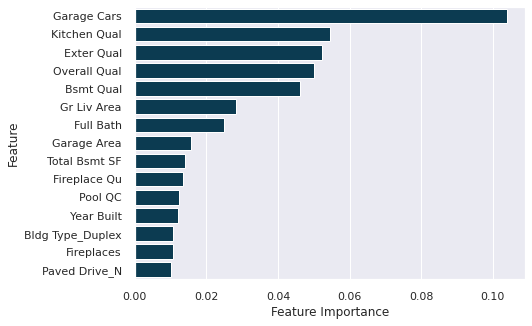

In [63]:
xgb_feature_importances = xgb_model.feature_importances_
xgb_feature_importances = pd.Series(
    xgb_feature_importances, index=X_train.columns.values
    ).sort_values(ascending=False).head(15)

fig, ax = plt.subplots(figsize=(7, 5))
sns.barplot(x=xgb_feature_importances, 
            y=xgb_feature_importances.index, 
            color="#003f5c");
plt.xlabel('Feature Importance');
plt.ylabel('Feature');

__SVR with gridsearch__

In [131]:
parameter_space = \
    {
        "kernel": ["poly", "linear", "rbf", "sigmoid"],
        "degree": [3, 5],
        "coef0": [0, 3, 7],
        "gamma":[.001, 0.01, 1/X_train.shape[1]],
        "C": [1, 10, 100],
    }

clf = GridSearchCV(SVR(), parameter_space, cv=3, n_jobs=4,
                   scoring="neg_mean_absolute_error")

clf.fit(X_train, y_train)
cv_df(clf)
print("Best parameters:")
print(clf.best_params_)

NameError: name 'SVR' is not defined

In [59]:
svr_model = SVR(**clf.best_params_)
svr_model.fit(X_train, y_train)
y_pred = svr_model.predict(X_test)
svr_mae = mean_absolute_error(y_test, y_pred)
print("Support Vector Regression MAE =", svr_mae)

Support Vector Regression MAE = 12675.935524811264


__plotowanie wyników, na razie bez DataFrame'a
wyniki przykładowe__

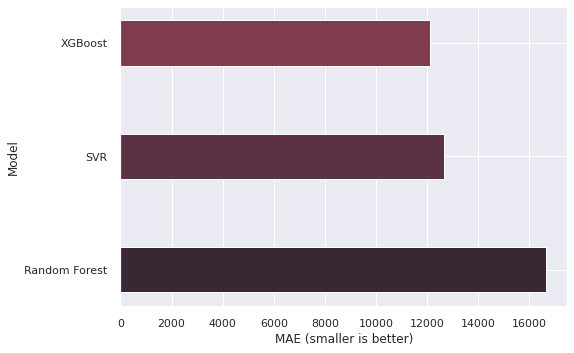

In [53]:
x = ['Random Forest', 'SVR', 'XGBoost']
y = [16632.77275, 12675.93, 12111.19]
colors = ["#392834", "#5a3244", "#7e3c4d"]
fig, ax = plt.subplots()
plt.barh(y=range(len(x)), tick_label=x, width=y, height=0.4, color=colors);
ax.set(xlabel="MAE (smaller is better)", ylabel="Model");

__KNeighborsRegressor__

In [29]:
params = {
    'n_neighbors': [3, 4, 5, 6],
    'weights': ['uniform','distance'],
    'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],
    'leaf_size': [10, 30, 30, 50, 50]
 }

knn = KNeighborsRegressor()
grid= GridSearchCV(knn, params, cv=5)
grid.fit(X_train, y_train)
cv_df(grid)
print(grid.best_params_)
print(grid.score(X_test, y_test))

knn_model = KNeighborsRegressor(**grid.best_params_)
knn_model.fit(X_train, y_train)
y_pred = knn_model.predict(X_test)
knn_rmse = math.sqrt(mean_squared_error(y_test, y_pred))
print("KNeighborsRegressor_RMSE=", knn_rmse)

cv_df(grid)

{'algorithm': 'auto', 'leaf_size': 10, 'n_neighbors': 6, 'weights': 'distance'}
0.7749029730049471
KNeighborsRegressor_RMSE= 36730.32052267049


,algorithm,leaf_size,n_neighbors,weights,score
0,auto,10,3,uniform,0.756884
1,auto,10,3,distance,0.757164
2,auto,10,4,uniform,0.768163
3,auto,10,4,distance,0.767627
4,auto,10,5,uniform,0.771310
...,...,...,...,...,...
155,brute,50,4,distance,0.734480
156,brute,50,5,uniform,0.754613
157,brute,50,5,distance,0.755379
158,brute,50,6,uniform,0.762877


In [5]:
def KNN_score (X_train, y_train, X_test, y_test):
    n_neighbors = [3, 4, 5, 6]
    weights = ['uniform','distance']
    algorithm = ['auto', 'ball_tree', 'kd_tree', 'brute']
    leaf_size = [10, 30, 30, 50, 50]
    best = 0
    best_model = ''
    for w in weights:
        for l in leaf_size:
            for n in n_neighbors:
                for a in algorithm:
                        model = KNeighborsRegressor(algorithm = a, 
                                weights = w, leaf_size = l, n_neighbors = n)
                        model.fit(X_train,y_train)
                        score = model.score(X_test,y_test)
                        if score > best:
                            best = score
                            best_model = f'score = {score} algorithm = {a} weights = {w} leaf_size = {l} n_neighbors = {n}'
    print(best_model)

In [44]:
def KNN_rmse (x_train, y_train, x_test, y_test): 
    n_neighbors = [3, 4, 5, 6]
    weights = ['uniform','distance']
    algorithm = ['auto', 'ball_tree', 'kd_tree', 'brute']
    leaf_size = [10, 30, 30, 50, 50]
    best = 100000
    best_model = ''
    for w in weights:
        for l in leaf_size:
            for n in n_neighbors:
                for a in algorithm:
                        model = KNeighborsRegressor(algorithm = a, 
                                weights = w, leaf_size = l, n_neighbors = n)
                        model.fit(X_train,y_train)
                        y_pred = model.predict(X_test)
                        mse = mean_squared_error(y_test, y_pred)
                        y_pred = model.predict(X_test)
                        rmse = math.sqrt(mean_squared_error(y_test, y_pred))
                        if rmse < best:
                            best = rmse
                            best_model = f'rmse = {rmse} algorithm = {a} weights = {w} leaf_size = {l} n_neighbors = {n}'
    print(best_model)

In [51]:
KNN_score(X_train, y_train, X_test, y_test)

score = 0.7760308147468868 algorithm = auto weights = distance leaf_size = 10 n_neighbors = 6


In [47]:
KNN_rmse(X_train, y_train, X_test, y_test)

rmse = 36638.186898000924 algorithm = auto weights = distance leaf_size = 10 n_neighbors = 6


In [125]:
print(os.listdir(directory))
print(directory)

['LinearRegression_20200710_194922.csv']
./results/


In [104]:
#odczytywanie wyników

In [138]:
directory = os.curdir + "/results/"

tabela = pd.DataFrame()

for file in os.listdir(directory):
    #iteracja przez wszystkie pliki w katalogu
    
    tmp = pd.read_csv("results/" + file, index_col= False) 
    
    # usunięcie zbędnej kolumny
    tmp = tmp.drop(columns = 'Unnamed: 0', axis = 0)
   
    # zkolalizowanie najwyższego score'a
    result = tmp['score'].idxmax()
    
    # przypisanie rzędu z najwyższym wyniku do słownika 
    max_score = dict(tmp.iloc[result])
    
    # wyciągnięcie nazwy modelu z pliku
    max_score['model']  = str(file).split(' ')[0]
    
    # dodanie rekordu do tabeli
    tabela = tabela.append((max_score), ignore_index = True)
    
tabela

,model,n_jobs,score,criterion,max_depth,min_samples_leaf,n_estimators,C,gamma,degree
0,LinearRegression_20200710_194922.csv,1.00,-2044357372913150066688.00,NaN,nan,nan,nan,nan,NaN,nan
1,RandomForestRegressor_20200710_195914.csv,nan,0.90,mse,13.00,25.00,125.00,nan,NaN,nan
2,SVR_20200710_200437.csv,nan,0.86,NaN,nan,nan,nan,10.00,scale,nan
3,SVR_20200710_201415.csv,nan,-0.02,NaN,nan,nan,nan,10.00,auto,9.00
